# Extrapolating line game model to new teaching stimuli

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

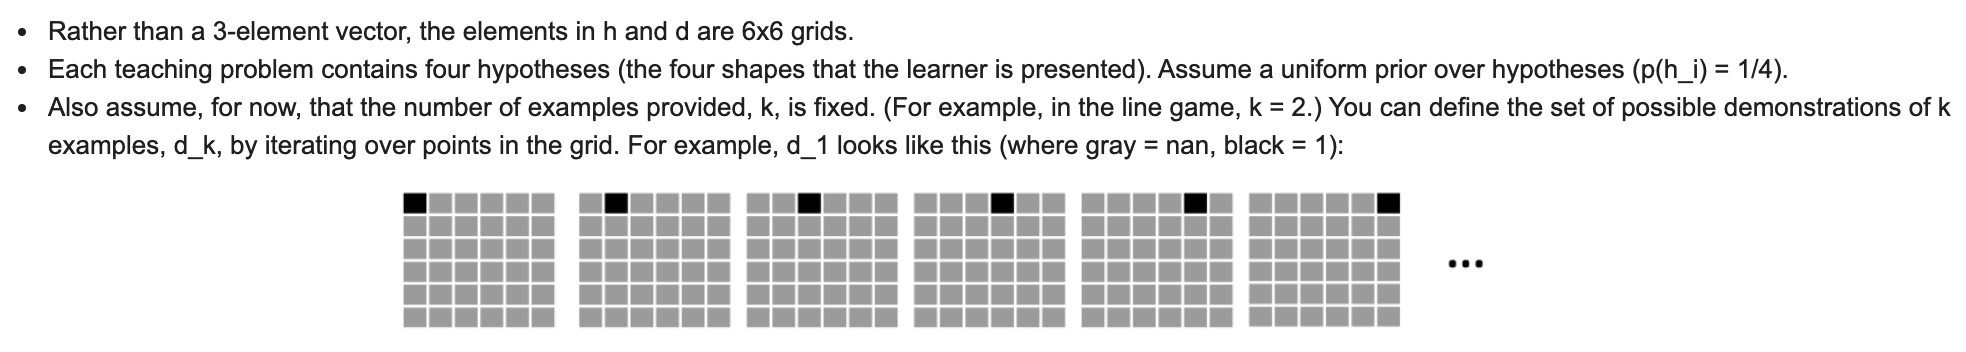

In [2]:
# Import all problems from spreadsheet

from make_df import make_df_from_spreadsheet

filename = 'teaching_stimuli - all_examples.csv'
all_problems = make_df_from_spreadsheet(filename)

In [3]:
def find_problem(index, all_problems):
    '''Return flat and non flat representations of a specific problem'''
    h = np.array([i for i in all_problems.loc[index,:].to_numpy(dtype=object)])
    h_flat = all_problems.loc[index,:].to_numpy(dtype=object) # Instead of 3d matrix, create an array of arrays
    #print(h.shape)
    #print(h_flat.shape)
    return h, h_flat

In [4]:
h, h_flat = find_problem(34, all_problems)

## View problem

In [5]:
def plot_problem(problem):
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080')
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 

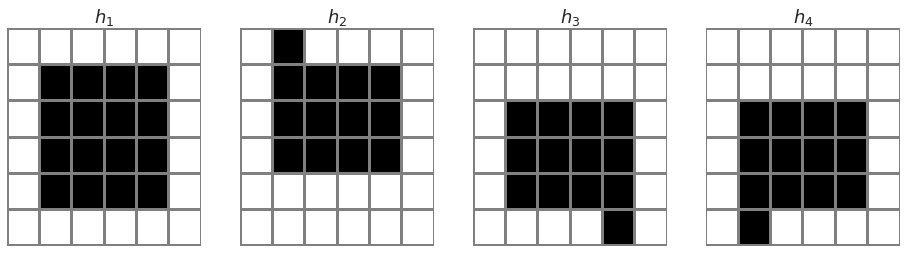

In [6]:
plot_problem(h)

## Start with $k=1$

In [7]:
# Get possible positive examples
# Don't need a mask here b/c we are already choosing from the positive examples

def get_pos_idx(concept):
    pos_coords = np.nonzero(concept)
    pos_idx = np.ravel_multi_index(pos_coords, (6,6))

    return list(pos_idx)

In [8]:
def find_pos_ex_indices(h_flat):
    '''
    Extract indices (flattened) of positive examples (starting from 0) for each h
    '''
    d_possible = {}
    #columns = ['h_1', 'h_2', 'h_3', 'h_4']
    #rows = ['d_%i' % (i+1) for i in range(h_flat[0].size)]

    for ex in range(len(h_flat)):
        d_possible[ex] = get_pos_idx(h_flat[ex])
    return d_possible

In [9]:
d_possible = find_pos_ex_indices(h_flat)
d_possible

{0: [7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28],
 1: [1, 7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22],
 2: [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 34],
 3: [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 31]}

In [10]:
def make_df_iteration_zero(d_possible):
    df_0 = pd.DataFrame(index=[i for i in range(h_flat[0].size)], columns=[i for i in range(h_flat.size)])

    for k, v in d_possible.items(): 
        for i in v:
            df_0.loc[i, k] = 1
            
    # Drop rows without possible hypotheses, fill remaining NaNs with 0 
    # df_0 = df_0.dropna(how='all').fillna(0)

    # Columns should sum up to one (prior for each hypothesis is that you have an equal chance of teaching any of the data)
    df_0 = df_0.div(df_0.sum(axis=0), axis=1)
    df_0 = df_0.fillna(0)
    
    df_0.columns = ['h_1', 'h_2', 'h_3', 'h_4']
    return df_0

In [11]:
# View
df_0 = make_df_iteration_zero(d_possible)

In [12]:
df_0

,h_1,h_2,h_3,h_4
0,0.0000,0.000000,0.000000,0.000000
1,0.0000,0.076923,0.000000,0.000000
2,0.0000,0.000000,0.000000,0.000000
3,0.0000,0.000000,0.000000,0.000000
4,0.0000,0.000000,0.000000,0.000000
5,0.0000,0.000000,0.000000,0.000000
6,0.0000,0.000000,0.000000,0.000000
7,0.0625,0.076923,0.000000,0.000000
8,0.0625,0.076923,0.000000,0.000000
9,0.0625,0.076923,0.000000,0.000000


In [13]:
def plot_prob_heatmap(df, title):
    plt.figure(figsize=(4.8,7))
    sns.heatmap(df, annot=True, linewidths=0.25)
    plt.title(title)
    plt.show()

In [14]:
# Plot heatmap w/o 0 rows
#plot_prob_heatmap(df_0.loc[(df_0!=0).any(axis=1)])

In [15]:
def find_teacher_probabilities_given_iter_0(n, df_0):
    '''
    given number of iterations n and P(d|h) matrix for iteration 0, find P(d|h) and P(h|d) matrix after iteration n 
    '''
    n_iter = n
    df_d = df_0

    for n in range(n_iter): 
        df_h = df_d.div(df_d.sum(axis=1), axis=0)  # P(h|d)
        df_d = df_h.div(df_h.sum(axis=0), axis=1)  # P(d|h)
    
    if n_iter == 0: 
        df_d = df_0 
        df_h = df_d.div(df_d.sum(axis=1), axis=0)
        
    return df_d, df_h

In [16]:
def find_teacher_probs_k1(n_iter, prob_idx, all_problems):
    '''given iteration number, index of problem, and df of all problems, return P(d|h) and P(h|d) after n interations for k=1'''
    _, h_flat = find_problem(prob_idx, all_problems)
    d_possible = find_pos_ex_indices(h_flat)
    df_0 = make_df_iteration_zero(d_possible)
    df_d, df_h = find_teacher_probabilities_given_iter_0(n_iter, df_0)
    return df_d.fillna(0), df_h.fillna(0)

In [17]:
def drop_zero_rows(df):
    df = df.loc[(df!=0).any(axis=1)]
    return df

In [18]:
# Example: index 34, after 500 iterations
df_d_500, df_h_500 = find_teacher_probs_k1(500, 34, all_problems)

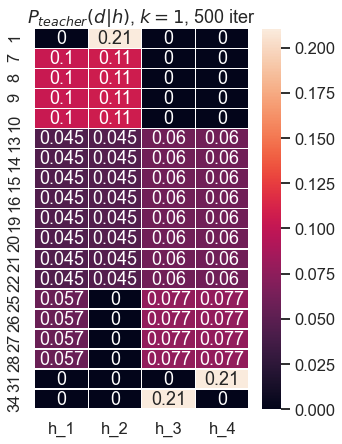

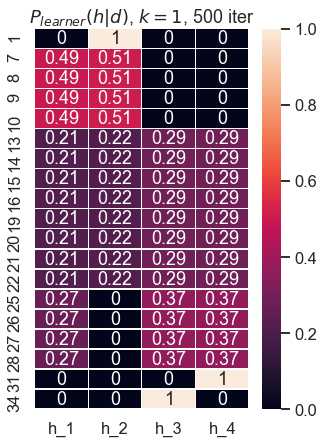

In [19]:
plot_prob_heatmap(drop_zero_rows(df_d_500), '$P_{teacher}(d|h)$, $k=1$, 500 iter')
plot_prob_heatmap(drop_zero_rows(df_h_500), '$P_{learner}(h|d)$, $k=1$, 500 iter')

In [20]:
# Plot indices to make viz slightly easier
def plot_problem_with_indices(problem):
    
    indices = np.arange(0, h_flat[0].size).reshape(6,6)
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    opt_labels = '0123'

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='gray_r', cbar=False,
                         linewidths=2, linecolor='#808080', annot=indices)
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 

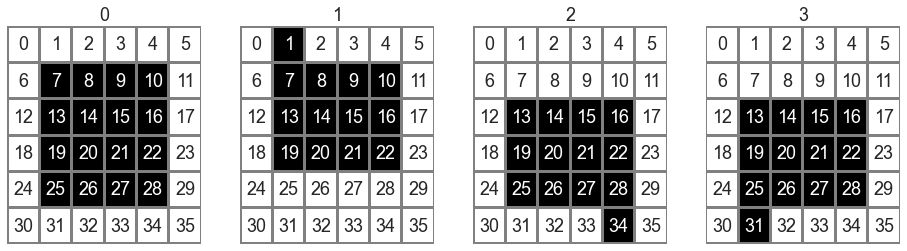

In [21]:
plot_problem_with_indices(h)

In [22]:

def plot_prob_heatmap_k1(df, title):
    '''Plot probabilities heatmap given probabilities df'''
    problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle(title, y=1.1)
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 
    #return problem

In [23]:
def make_prob_heatmap_k1(df):
    probs = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    return probs

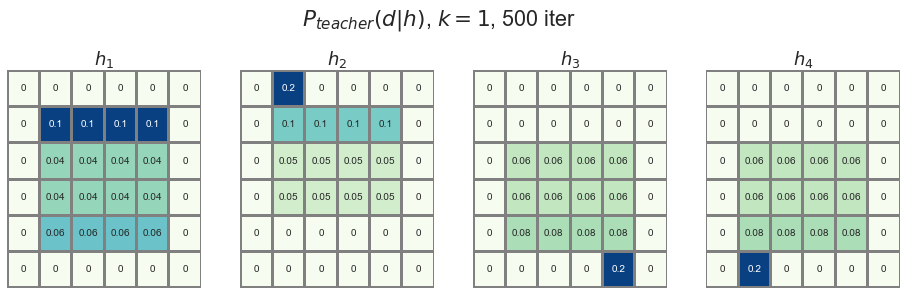

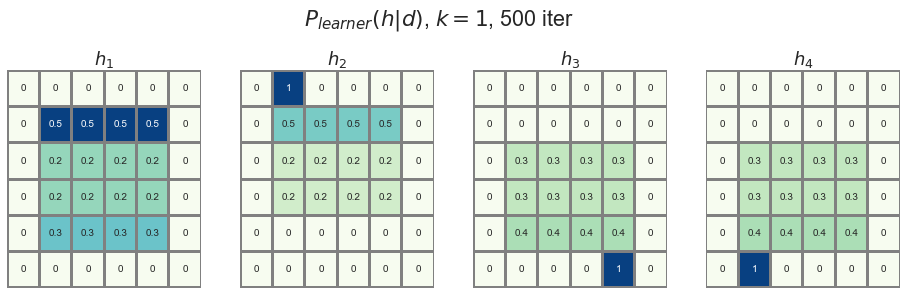

In [24]:
plot_prob_heatmap_k1(df_d_500, '$P_{teacher}(d|h)$, $k=1$, 500 iter')
plot_prob_heatmap_k1(df_h_500, '$P_{learner}(h|d)$, $k=1$, 500 iter')

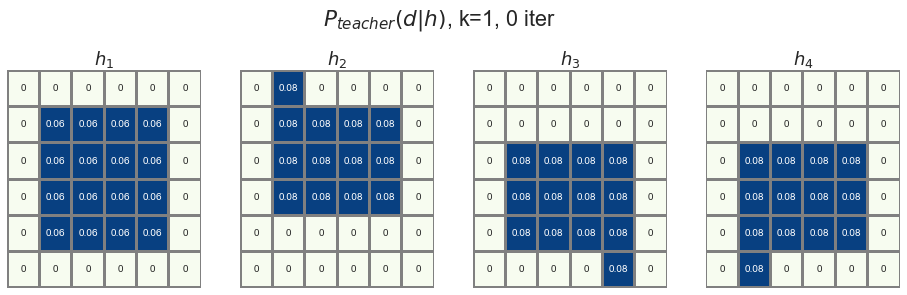

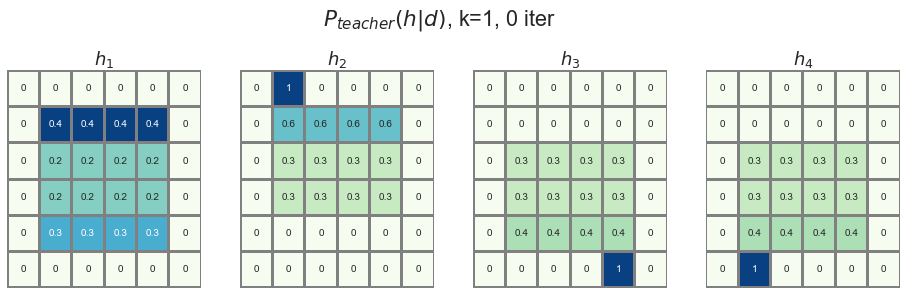

In [25]:
df_d_0 = df_0
df_h_0 = find_teacher_probabilities_given_iter_0(1, df_d_0)[1].fillna(0)
plot_prob_heatmap_k1(df_d_0, '$P_{teacher}(d|h)$, k=1, 0 iter')
plot_prob_heatmap_k1(df_h_0, '$P_{teacher}(h|d)$, k=1, 0 iter')

## Cases of $k > 1$ 

In [26]:
def make_empty_df_3ex():
    indices = []
    for i in range(36):
        for j in range(i+1, 36):
            for k in range(j+1, 36):
                indices.append((i,j,k))

    indices = pd.MultiIndex.from_tuples(indices, names=('i_1', 'i_2', 'i_3'))
    df_3ex = pd.DataFrame(columns=['h_1', 'h_2', 'h_3', 'h_4'], index=indices) # should have 36 choose 3 rows
    
    return df_3ex

In [27]:
df_3ex = make_empty_df_3ex()
df_3ex

h_1  h_2  h_3  h_4
i_1 i_2 i_3                    
0   1   2    NaN  NaN  NaN  NaN
        3    NaN  NaN  NaN  NaN
        4    NaN  NaN  NaN  NaN
        5    NaN  NaN  NaN  NaN
        6    NaN  NaN  NaN  NaN
...          ...  ...  ...  ...
31  34  35   NaN  NaN  NaN  NaN
32  33  34   NaN  NaN  NaN  NaN
        35   NaN  NaN  NaN  NaN
    34  35   NaN  NaN  NaN  NaN
33  34  35   NaN  NaN  NaN  NaN

[7140 rows x 4 columns]

In [28]:
def make_empty_df_2ex():
    indices = []
    for i in range(36):
        for j in range(i+1, 36):
            indices.append((i,j))

    indices = pd.MultiIndex.from_tuples(indices, names=('i_1', 'i_2'))
    df_2ex = pd.DataFrame(columns=['h_1', 'h_2', 'h_3', 'h_4'], index=indices)
    
    return df_2ex

In [29]:
df_2ex = make_empty_df_2ex()
df_2ex

h_1  h_2  h_3  h_4
i_1 i_2                    
0   1    NaN  NaN  NaN  NaN
    2    NaN  NaN  NaN  NaN
    3    NaN  NaN  NaN  NaN
    4    NaN  NaN  NaN  NaN
    5    NaN  NaN  NaN  NaN
...      ...  ...  ...  ...
32  34   NaN  NaN  NaN  NaN
    35   NaN  NaN  NaN  NaN
33  34   NaN  NaN  NaN  NaN
    35   NaN  NaN  NaN  NaN
34  35   NaN  NaN  NaN  NaN

[630 rows x 4 columns]

In [30]:
def make_d_possible_with_column_labels(h_flat): 
    columns = ['h_1', 'h_2', 'h_3', 'h_4']
    d_possible = find_pos_ex_indices(h_flat)

    new_d_possible = {}
    for ex in range(len(columns)):
        new_d_possible[columns[ex]] = d_possible[ex]

    return new_d_possible

In [31]:
def normalize_probs_and_fill_nans(df): 
    df = df.div(df.sum(axis=0), axis=1)
    df = df.fillna(0)
    return df

In [32]:
new_d_possible = make_d_possible_with_column_labels(h_flat)
new_d_possible

{'h_1': [7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28],
 'h_2': [1, 7, 8, 9, 10, 13, 14, 15, 16, 19, 20, 21, 22],
 'h_3': [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 34],
 'h_4': [13, 14, 15, 16, 19, 20, 21, 22, 25, 26, 27, 28, 31]}

### $k = 2$

In [33]:
def fill_df_2ex(h_flat):
    '''Fill df with initial probabilities'''
    df_2ex = make_empty_df_2ex()
    new_d_possible = make_d_possible_with_column_labels(h_flat)
    
    for column in df_2ex.columns:
        for i, j in df_2ex.index:
            if i in new_d_possible[column] and j in new_d_possible[column]:
                df_2ex.loc[(i,j), column] = 1
    
    df_2ex_short = df_2ex.dropna(how='all')
    
    df_2ex = normalize_probs_and_fill_nans(df_2ex)
    df_2ex_short = normalize_probs_and_fill_nans(df_2ex_short)
    
    return df_2ex, df_2ex_short

In [34]:
def find_teacher_probs_k2(n_iter, prob_idx, all_problems):
    '''given iteration number, index of problem, and df of all problems, return P(d|h) and P(h|d) after n interations for k=2'''
    _, h_flat = find_problem(prob_idx, all_problems)
    df_2ex_0, _ = fill_df_2ex(h_flat)
    df_d, df_h = find_teacher_probabilities_given_iter_0(n_iter, df_2ex_0)
    return df_d.fillna(0), df_h.fillna(0)

In [35]:
df_d_500_2ex, df_h_500_2ex = find_teacher_probs_k2(500, 34, all_problems)

In [36]:
# Sanity check 
df_d_500_2ex.sum(axis=0)

h_1    1.0
h_2    1.0
h_3    1.0
h_4    1.0
dtype: float64

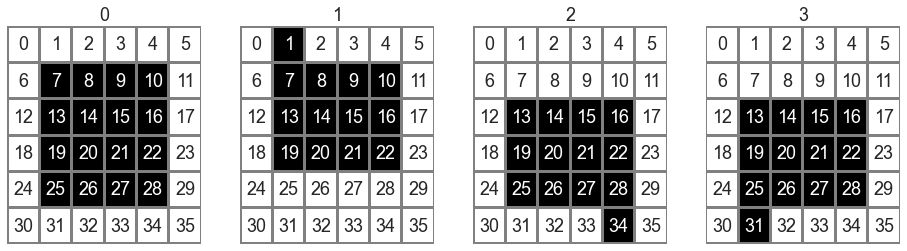

In [37]:
plot_problem_with_indices(h)

In [38]:
# Sort by what examples would be the best for h1
df_d_500_2ex.sort_values(by=['h_1'], ascending=False).head(10)

h_1  h_2  h_3  h_4
i_1 i_2                         
9   27   0.025641  0.0  0.0  0.0
7   26   0.025641  0.0  0.0  0.0
8   25   0.025641  0.0  0.0  0.0
    26   0.025641  0.0  0.0  0.0
9   28   0.025641  0.0  0.0  0.0
10  25   0.025641  0.0  0.0  0.0
    26   0.025641  0.0  0.0  0.0
    27   0.025641  0.0  0.0  0.0
    28   0.025641  0.0  0.0  0.0
8   27   0.025641  0.0  0.0  0.0

In [39]:
def make_prob_heatmap_k2(df):
    probs = np.array([np.zeros((6,6)) for column in df.columns])
    for h_idx in range(df.columns.size):
        for i_1, i_2 in df.index:
            probs[h_idx, np.unravel_index(i_1, (6,6))[0], np.unravel_index(i_1, (6,6))[1]] += df.loc[(i_1, i_2), df.columns[h_idx]]
            probs[h_idx, np.unravel_index(i_2, (6,6))[0], np.unravel_index(i_2, (6,6))[1]] += df.loc[(i_1, i_2), df.columns[h_idx]]
            
    # correct for double counting
    # probs = probs / 2
    return probs
#np.unravel_index(1621, (6,7,8,9))

In [40]:
probabilities = make_prob_heatmap_k2(df_d_500_2ex)

In [41]:
def plot_problem_heatmap(df, title):
    '''Plot probabilities heatmap given probabilities df'''
    problem = df
    #problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle(title, y=1.1)
    opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[], title=opt_labels[idx]) 
    #return problem

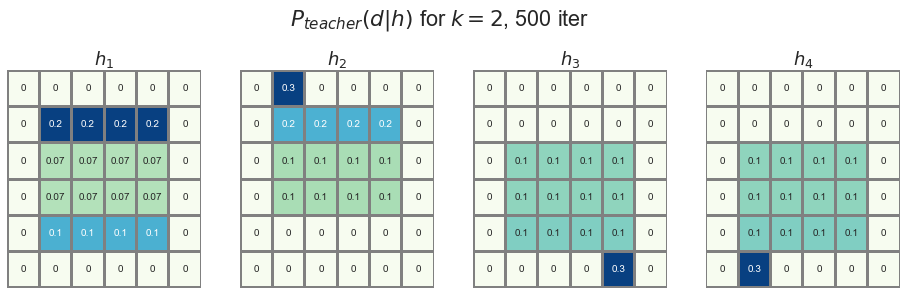

In [42]:
plot_problem_heatmap(probabilities, '$P_{teacher}(d|h)$ for $k=2$, 500 iter')

### $k=3$

In [43]:
def fill_df_3ex(h_flat):
    '''Fill df with initial probabilities'''
    df_3ex = make_empty_df_3ex()
    new_d_possible = make_d_possible_with_column_labels(h_flat)
    
    for column in df_3ex.columns:
        for i, j, k in df_3ex.index:
            if i in new_d_possible[column] and j in new_d_possible[column] and k in new_d_possible[column]:
                df_3ex.loc[(i,j,k), column] = 1
    
    df_3ex_short = df_3ex.dropna(how='all')
    
    df_3ex = normalize_probs_and_fill_nans(df_3ex)
    df_3ex_short = normalize_probs_and_fill_nans(df_3ex_short)
    
    return df_3ex, df_3ex_short

In [44]:
def find_teacher_probs_k3(n_iter, prob_idx, all_problems):
    '''given iteration number, index of problem, and df of all problems, return P(d|h) and P(h|d) after n interations for k=2'''
    _, h_flat = find_problem(prob_idx, all_problems)
    df_0, _ = fill_df_3ex(h_flat)
    df_d, df_h = find_teacher_probabilities_given_iter_0(n_iter, df_0)
    return df_d.fillna(0), df_h.fillna(0)

In [45]:
def make_prob_heatmap_k3(df):
    probs = np.array([np.zeros((6,6)) for column in df.columns])
    for h_idx in range(df.columns.size):
        for i_1, i_2, i_3 in df.index:
            probs[h_idx, np.unravel_index(i_1, (6,6))[0], np.unravel_index(i_1, (6,6))[1]] += df.loc[(i_1, i_2, i_3), df.columns[h_idx]]
            probs[h_idx, np.unravel_index(i_2, (6,6))[0], np.unravel_index(i_2, (6,6))[1]] += df.loc[(i_1, i_2, i_3), df.columns[h_idx]]
            probs[h_idx, np.unravel_index(i_3, (6,6))[0], np.unravel_index(i_3, (6,6))[1]] += df.loc[(i_1, i_2, i_3), df.columns[h_idx]]
    # correct for double counting
    # probs = probs / 6
    return probs
#np.unravel_index(1621, (6,7,8,9))

In [46]:
df_d_500_3ex, df_h_500_3ex = find_teacher_probs_k3(500, 34, all_problems)

In [47]:
#df_d.sort_values(by=['h_1'], ascending=False).head(10)

In [48]:
probs_3 = make_prob_heatmap_k3(df_d_500_3ex)

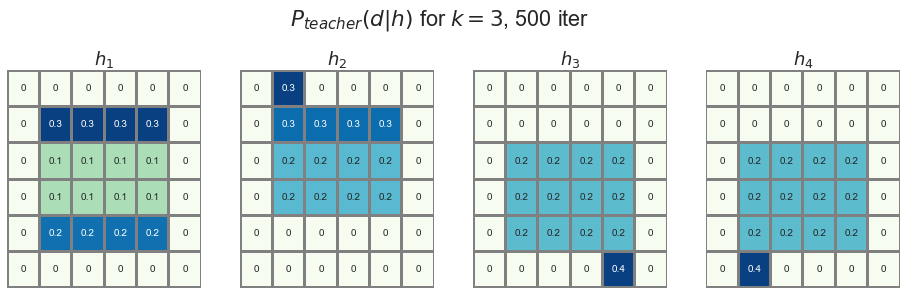

In [49]:
plot_problem_heatmap(probs_3, '$P_{teacher}(d|h)$ for $k=3$, 500 iter')

## Putting everything together

In [50]:
def find_teacher_probs(n_iter, prob_idx, all_problems):
    """Creates a dict of probability dataframes, indexed by k value and whether it is P(d|h) or P(h|d)"""
    my_dict = {}
    my_dict['n_iter'] = n_iter
    my_dict['problem_index'] = prob_idx
    
    for k in range(1,4):
        my_dict[k] = {}
    
    my_dict[1]['d'], my_dict[1]['h'] = find_teacher_probs_k1(n_iter, prob_idx, all_problems)
    my_dict[2]['d'], my_dict[2]['h'] = find_teacher_probs_k2(n_iter, prob_idx, all_problems)
    my_dict[3]['d'], my_dict[3]['h'] = find_teacher_probs_k3(n_iter, prob_idx, all_problems)
    
    return my_dict

In [51]:
# Example
all_probs = find_teacher_probs(500, 34, all_problems)

In [52]:
len(all_probs[3]['d'].index.names)

3

In [53]:
# Accessing p(h|d) for k=3 and sorting
all_probs[3]['d'].sort_values(by=['h_1'], ascending=False).head(10)

h_1  h_2  h_3  h_4
i_1 i_2 i_3                         
8   19  25   0.004926  0.0  0.0  0.0
    9   26   0.004926  0.0  0.0  0.0
9   21  25   0.004926  0.0  0.0  0.0
        26   0.004926  0.0  0.0  0.0
        27   0.004926  0.0  0.0  0.0
        28   0.004926  0.0  0.0  0.0
8   9   28   0.004926  0.0  0.0  0.0
        27   0.004926  0.0  0.0  0.0
        25   0.004926  0.0  0.0  0.0
10  19  25   0.004926  0.0  0.0  0.0

In [54]:
# creating a dict with 0 and 500 iterations

probs = {}
probs[0] = find_teacher_probs(0, 34, all_problems)
probs[500] = find_teacher_probs(500, 34, all_problems)

In [55]:
# visualizing results 

def make_prob_heatmap(df):
    if len(df.index.names) == 1:
        heatmap = make_prob_heatmap_k1(df)
    elif len(df.index.names) == 2:
        heatmap = make_prob_heatmap_k2(df)
    else:
        heatmap = make_prob_heatmap_k3(df)
        
    return heatmap

In [56]:
def make_and_plot_prob_heatmap(df, title):
    heatmap = make_prob_heatmap(df)
    plot_problem_heatmap(heatmap, title)
    return heatmap

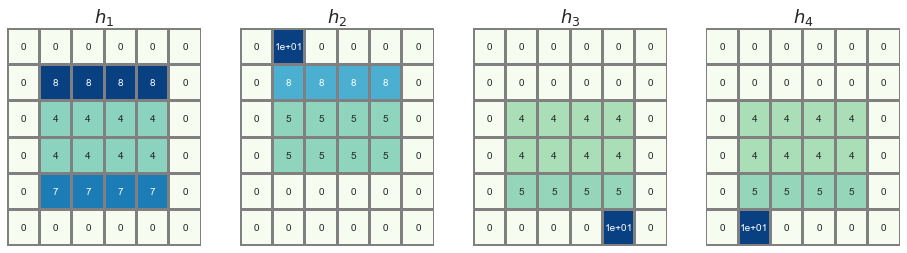

In [57]:
hm0 = make_and_plot_prob_heatmap(probs[0][2]['h'], '')

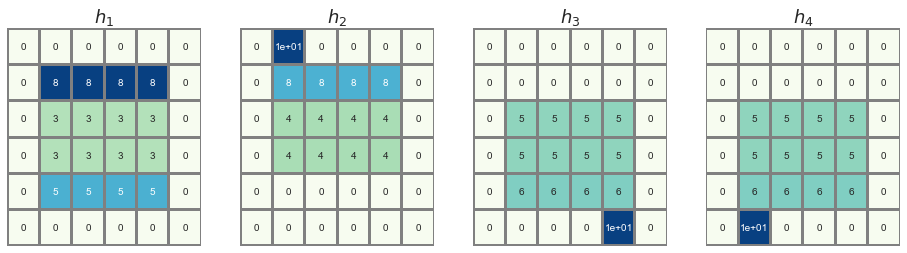

In [58]:
hm500 = make_and_plot_prob_heatmap(probs[500][2]['h'], '')

In [59]:
probs[500][2]['h'].sort_values(by=['h_1'], ascending=False).head(20)

h_1       h_2  h_3  h_4
i_1 i_2                              
9   27   1.000000  0.000000  0.0  0.0
7   26   1.000000  0.000000  0.0  0.0
8   25   1.000000  0.000000  0.0  0.0
    26   1.000000  0.000000  0.0  0.0
9   28   1.000000  0.000000  0.0  0.0
10  25   1.000000  0.000000  0.0  0.0
    26   1.000000  0.000000  0.0  0.0
    27   1.000000  0.000000  0.0  0.0
    28   1.000000  0.000000  0.0  0.0
8   27   1.000000  0.000000  0.0  0.0
    28   1.000000  0.000000  0.0  0.0
7   28   1.000000  0.000000  0.0  0.0
    27   1.000000  0.000000  0.0  0.0
    25   1.000000  0.000000  0.0  0.0
9   25   1.000000  0.000000  0.0  0.0
    26   1.000000  0.000000  0.0  0.0
8   21   0.403707  0.596293  0.0  0.0
9   10   0.403707  0.596293  0.0  0.0
    13   0.403707  0.596293  0.0  0.0
    14   0.403707  0.596293  0.0  0.0

In [60]:
def sort_values_ascending_by_column(df, label):
    df = df.sort_values(by=[label], ascending=False)
    return df

## Example

In [61]:
problem_35 = {}
problem_35[0] = find_teacher_probs(0, 35, all_problems)  # 0 iterations
problem_35[500] = find_teacher_probs(500, 35, all_problems)  # 500 iterations

In [62]:
problem_35.keys()

dict_keys([0, 500])

In [63]:
problem_35[0].keys()

dict_keys(['n_iter', 'problem_index', 1, 2, 3])

In [64]:
iters = [0, 500]
k_values = [1, 2, 3]
types = {'d': '$P(d|h)$', 'h': '$P(h|d)$'}

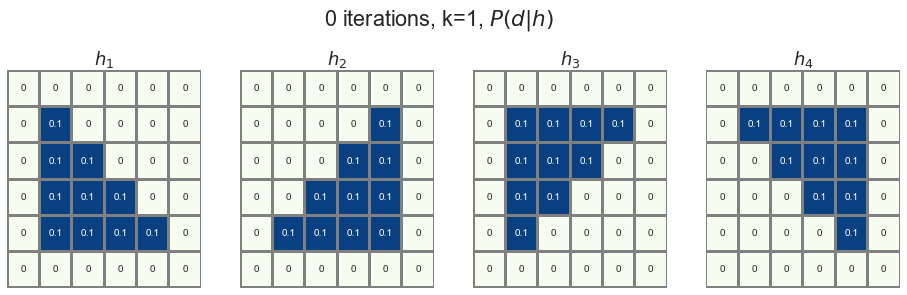

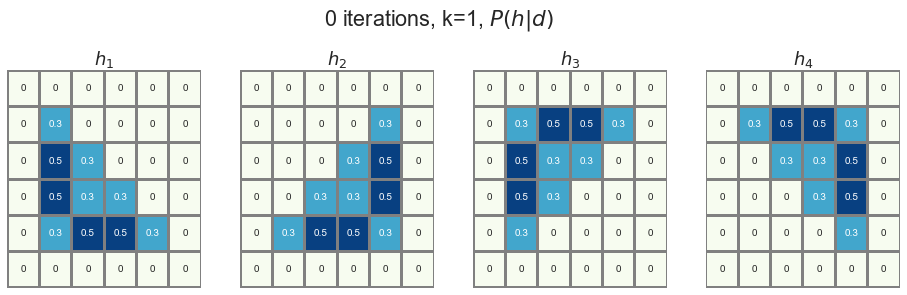

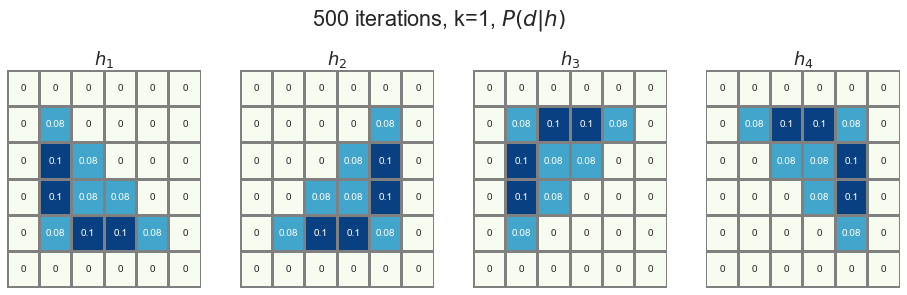

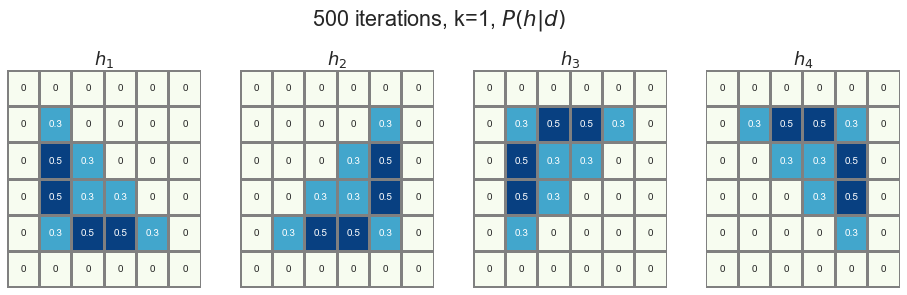

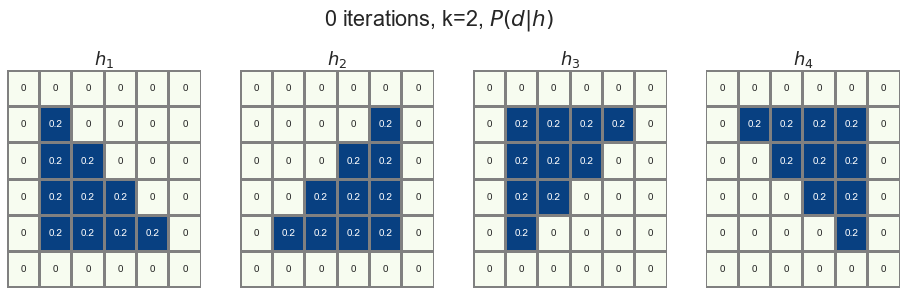

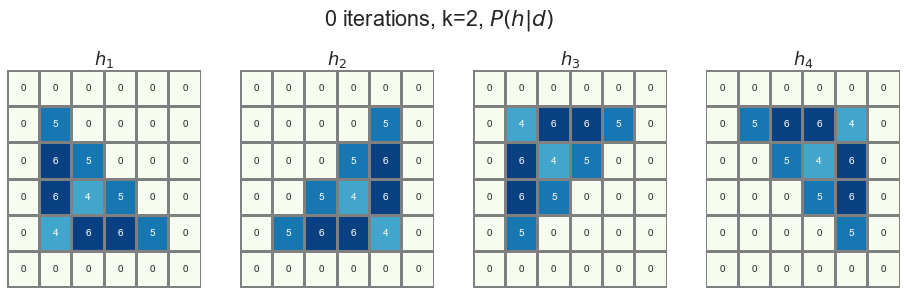

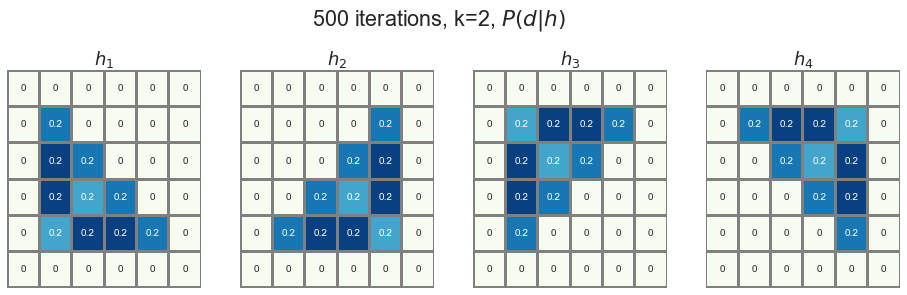

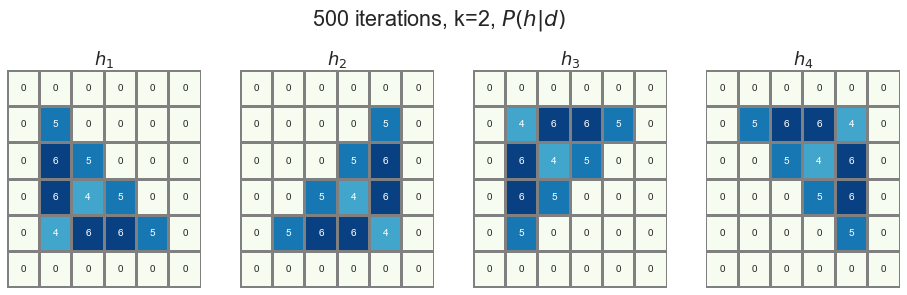

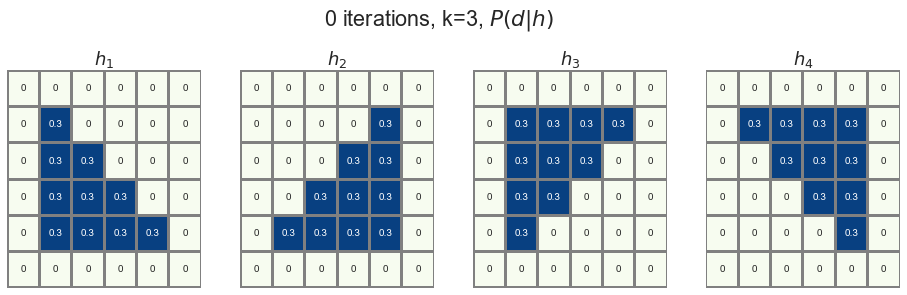

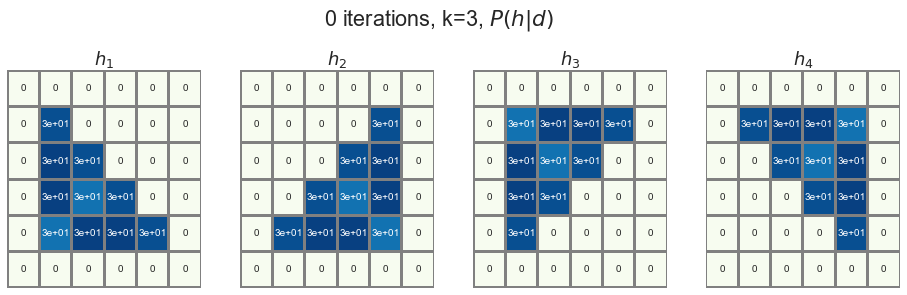

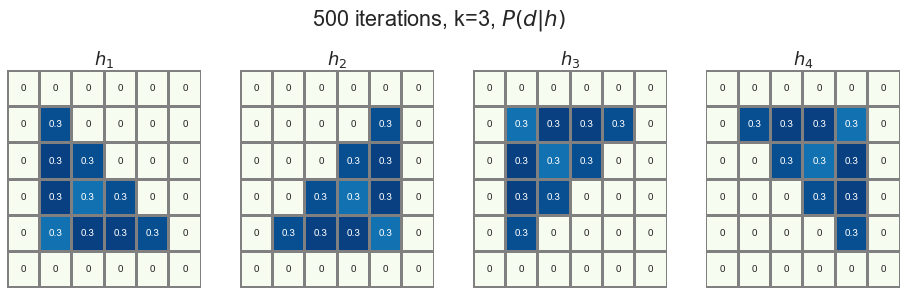

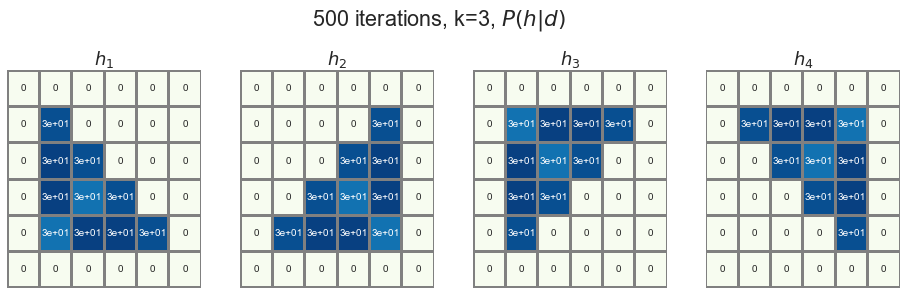

In [65]:
for k in k_values:
    for i in iters:
        for t, v in types.items(): 
            _ = make_and_plot_prob_heatmap(problem_35[i][k][t], f'{i} iterations, k={k}, {v}')

# Note: probs for k values greater than 1 are not normalized 

### Plot a few high-probability examples

In [66]:
sort_values_ascending_by_column(problem_35[500][2]['d'], 'h_1').head(20)

h_1  h_2       h_3  h_4
i_1 i_2                              
13  21   0.035714  0.0  0.000000  0.0
7   26   0.035714  0.0  0.000000  0.0
19  21   0.035714  0.0  0.000000  0.0
14  27   0.035714  0.0  0.000000  0.0
    26   0.035714  0.0  0.000000  0.0
13  26   0.035714  0.0  0.000000  0.0
    27   0.035714  0.0  0.000000  0.0
    28   0.035714  0.0  0.000000  0.0
19  27   0.035714  0.0  0.000000  0.0
7   27   0.035714  0.0  0.000000  0.0
19  26   0.035714  0.0  0.000000  0.0
    28   0.035714  0.0  0.000000  0.0
14  20   0.017857  0.0  0.017857  0.0
7   19   0.017857  0.0  0.017857  0.0
14  19   0.017857  0.0  0.017857  0.0
13  19   0.017857  0.0  0.017857  0.0
    20   0.017857  0.0  0.017857  0.0
14  25   0.017857  0.0  0.017857  0.0
13  25   0.017857  0.0  0.017857  0.0
7   25   0.017857  0.0  0.017857  0.0

In [67]:
test_df = sort_values_ascending_by_column(problem_35[500][3]['d'], 'h_1').head(4)
for i, row in test_df.reset_index().iterrows():
    print(i)
    print(int(row['i_1']))

0
7
1
7
2
19
3
14


In [68]:
def plot_some_examples(df, title):
    ''''''
    problem = df
    #problem = np.array([df[i].fillna(0).to_numpy().reshape(6,6) for i in df.columns])
    
    fig, ax = plt.subplots(1,4, figsize = (16,4))
    fig.suptitle(title, y=1.1)
    # opt_labels = ['$h_1$', '$h_2$', '$h_3$', '$h_4$']

    for idx,ax_i in enumerate(ax):
        hm = sns.heatmap(problem[idx,:,:], ax=ax_i,
                         cmap='GnBu', cbar=False,
                         linewidths=2, linecolor='#808080', annot=True, fmt='.1g', annot_kws={"size":10})
        ax_i.set(xticks=[], yticks=[]) 
    #return problem
        

In [69]:
def plot_high_prob_examples(prob, n_iter, types, idx, all_problems):
    '''given a probability df, plots 4 high probablility examples alongside the problem (designated by idx) for h1'''
    plot_problem(find_problem(idx, all_problems)[0]) 
    for k in range(1, 4):
        df = prob[n_iter][k][types]
        df = sort_values_ascending_by_column(df, 'h_1')
        ex = np.array([np.zeros((6,6)) for column in df.columns])
        #print(df)
        try: 
            _ = df.index.levels
        except AttributeError: 
            for i, row in df.head(4).reset_index().iterrows():
                ex[i, np.unravel_index(int(row[0]), (6,6))[0], np.unravel_index(int(row[0]), (6,6))[1]] = 1
        else:
            if len(df.index.levels) == 3: 
                for i, row in df.head(4).reset_index().iterrows():
                    ex[i, np.unravel_index(int(row['i_1']), (6,6))[0], np.unravel_index(int(row['i_1']), (6,6))[1]] = 1
                    ex[i, np.unravel_index(int(row['i_2']), (6,6))[0], np.unravel_index(int(row['i_2']), (6,6))[1]] = 1
                    ex[i, np.unravel_index(int(row['i_3']), (6,6))[0], np.unravel_index(int(row['i_3']), (6,6))[1]] = 1
            elif len(df.index.levels) == 2: 
                for i, row in df.head(4).reset_index().iterrows():
                    ex[i, np.unravel_index(int(row['i_1']), (6,6))[0], np.unravel_index(int(row['i_1']), (6,6))[1]] = 1
                    ex[i, np.unravel_index(int(row['i_2']), (6,6))[0], np.unravel_index(int(row['i_2']), (6,6))[1]] = 1

        plot_some_examples(ex, f'Examples for $h_1$, k={k}')
        
    
    #return ex

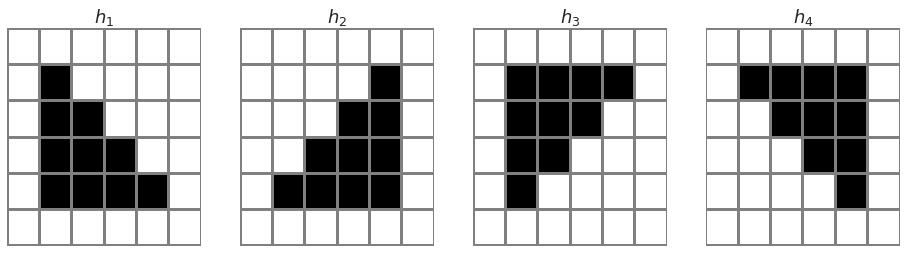

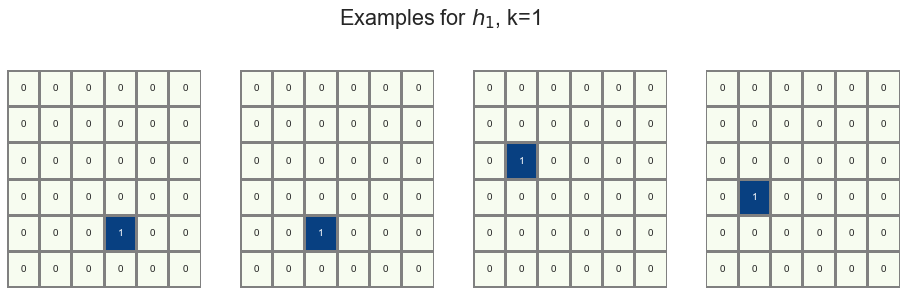

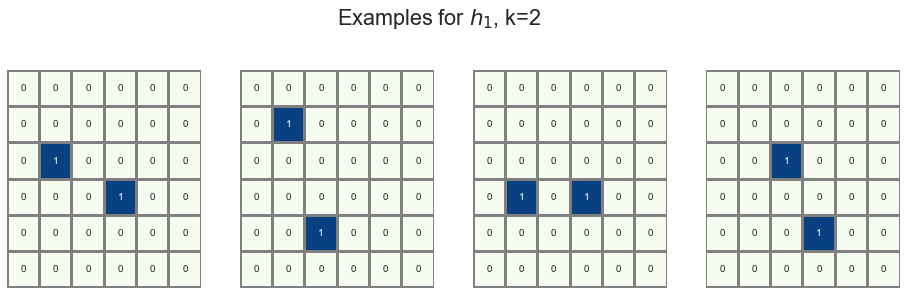

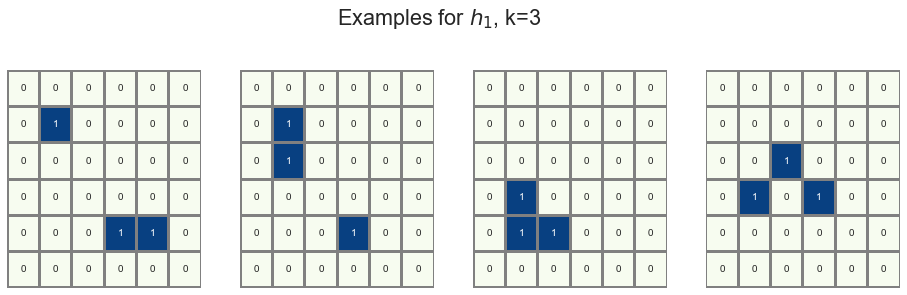

In [70]:
plot_high_prob_examples(problem_35, 500, 'd', 35, all_problems)